## Coronary Disease Prediction Model

Heart Disease is the leading cause of death in the United States, with Coronary Disease being the most common type. Common testing, including PET-CT Stress Tests and angiograms can be invasive and extremely expensive. Thus, my goal is to create a tool to assist doctors in sending less patients to these invasive measures, and be able to make their decisions more confidently.

The dataset for this project was developed from NHANES 2017-2020 data, in which just under three thousand patients were considered. The predictions will be made leveraging factors such as age, cholesterol, BMI, blood pressure, and more. All EDA and modeling will be done on 80% of the data, as a holdout file of 20% of the original data was left aside to test with the final, optimized model to test performance.

In order to develop a tool that physicians can confidently use, the output will contain a risk grouping, as well as a classification for whether or not the individual has Coronary Disease. Greater losses occur when we classify someone who actually has Coronary Disease as someone who does not, so we will aim for a model with high precision on the negative class, and this classification can be used if a physisician is leaning against further testing, which is both expensive and invasive.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import shap
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.utils import resample
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from tabulate import tabulate
import warnings

In [2]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "12"

In [3]:
data = pd.read_csv('modeling_data.csv')

## EDA Phase: Features and Correlations

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1916 entries, 0 to 1915
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SEQN                      1916 non-null   float64
 1   Gender                    1916 non-null   object 
 2   Education                 1916 non-null   object 
 3   Race_Eth                  1916 non-null   object 
 4   Age                       1916 non-null   float64
 5   Creatinine                1916 non-null   float64
 6   Glucose                   1916 non-null   float64
 7   HDL                       1916 non-null   float64
 8   Tchol                     1916 non-null   float64
 9   Trig                      1916 non-null   float64
 10  LDL                       1916 non-null   float64
 11  Smoker                    1916 non-null   float64
 12  Cholest_med               1916 non-null   int64  
 13  BMI                       1916 non-null   float64
 14  Systolic

In [5]:
data.head()

,SEQN,Gender,Education,Race_Eth,Age,Creatinine,Glucose,HDL,Tchol,Trig,LDL,Smoker,Cholest_med,BMI,Systolic_blood_pressure,Diastolic_blood_pressure,Coronary_dz,Asprin,Cotidine,Hydroxtcot
0,116210.0,Female,Some college or AA degree,Non-Hispanic White,52.0,0.57,95.0,40.0,180.0,127.0,115.0,1.0,0,39.4,121.333333,72.333333,0.0,0.0,9.175929e-81,1.100000e-02
1,123624.0,Male,High school graduate/GED or equivalent,Mexican American,72.0,1.05,115.0,42.0,170.0,214.0,85.0,1.0,0,31.5,118.666667,69.000000,0.0,0.0,1.100000e-02,1.100000e-02
2,117046.0,Female,High school graduate/GED or equivalent,Non-Hispanic Asian,58.0,0.54,165.0,61.0,208.0,165.0,114.0,0.0,0,25.5,128.666667,79.333333,0.0,1.0,1.100000e-02,1.100000e-02
3,118458.0,Female,High school graduate/GED or equivalent,Non-Hispanic White,65.0,1.12,95.0,94.0,216.0,79.0,106.0,0.0,0,25.1,116.000000,74.000000,0.0,0.0,3.508443e-80,7.070863e-80
4,112665.0,Male,Less than 9th grade,Mexican American,67.0,0.87,91.0,48.0,211.0,141.0,135.0,1.0,0,24.3,140.333333,71.666667,1.0,0.0,1.079521e-80,1.100000e-02


In [6]:
# What percent of the data set has coronary disease? Appears to be a single class classification problem.
print(np.mean(data['Coronary_dz']))

0.059498956158663886


In [7]:
# Function to plot the relationship between categorical variables and coronary disease

def plotter(data,x,y):
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    sns.pointplot(data = data,x = x,y = y,ax=ax[0])
    ax[0].set_title(f'{y} vs {x}')
    sns.histplot(data = data,x = x, ax=ax[1])
    ax[1].set_title(f'{x}')
    ax[0].tick_params(labelrotation=90)
    ax[1].tick_params(labelrotation=90)

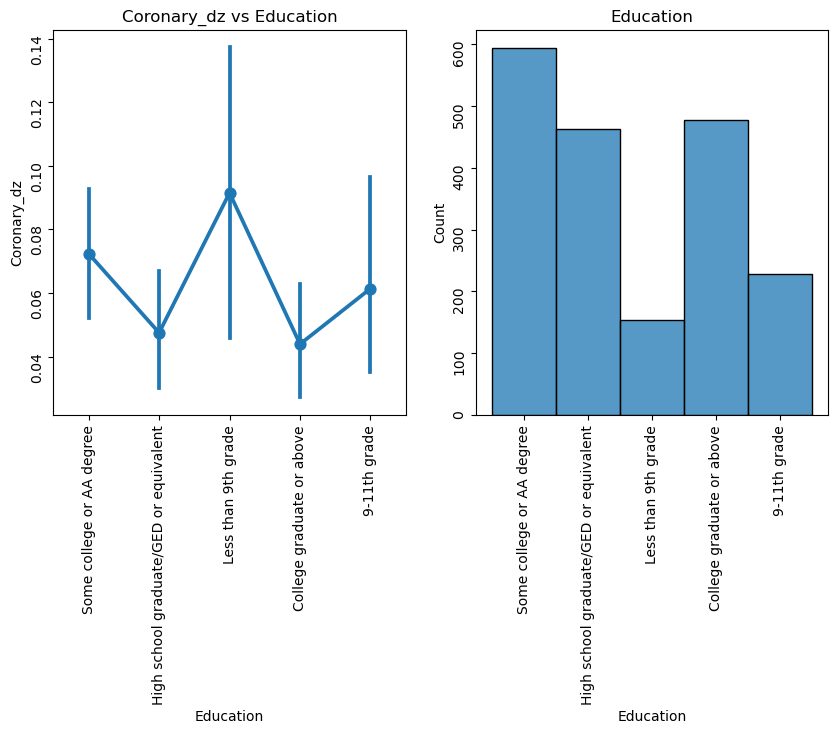

In [8]:
plotter(data, 'Education','Coronary_dz')

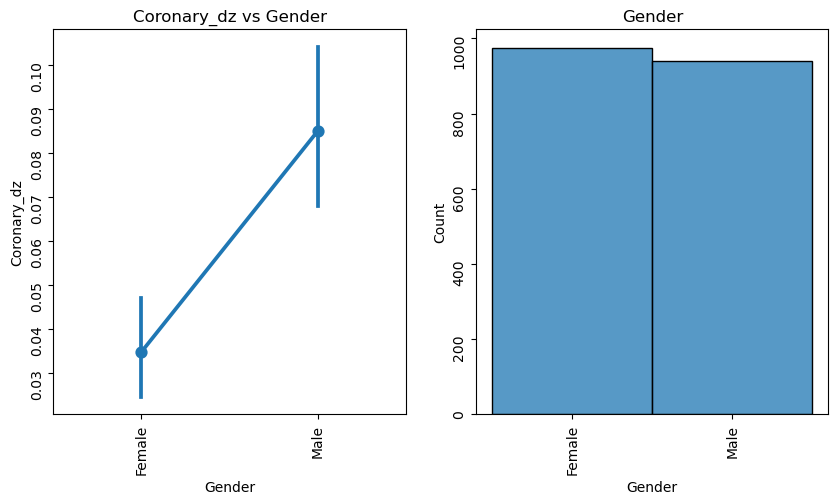

In [9]:
plotter(data, 'Gender', 'Coronary_dz')

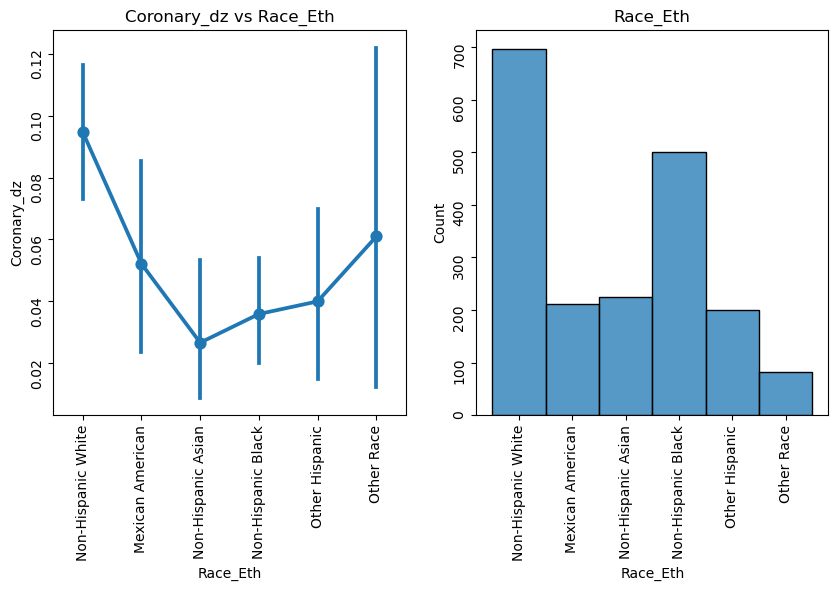

In [10]:
plotter(data, 'Race_Eth', 'Coronary_dz')

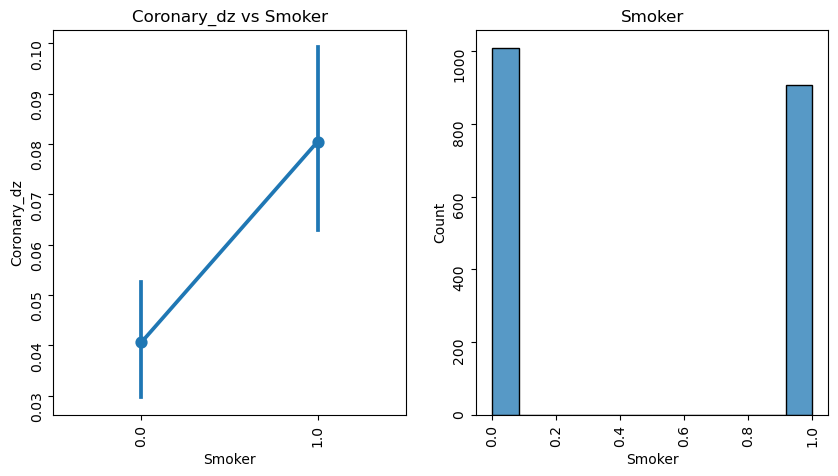

In [11]:
plotter(data,'Smoker','Coronary_dz')

<Axes: >

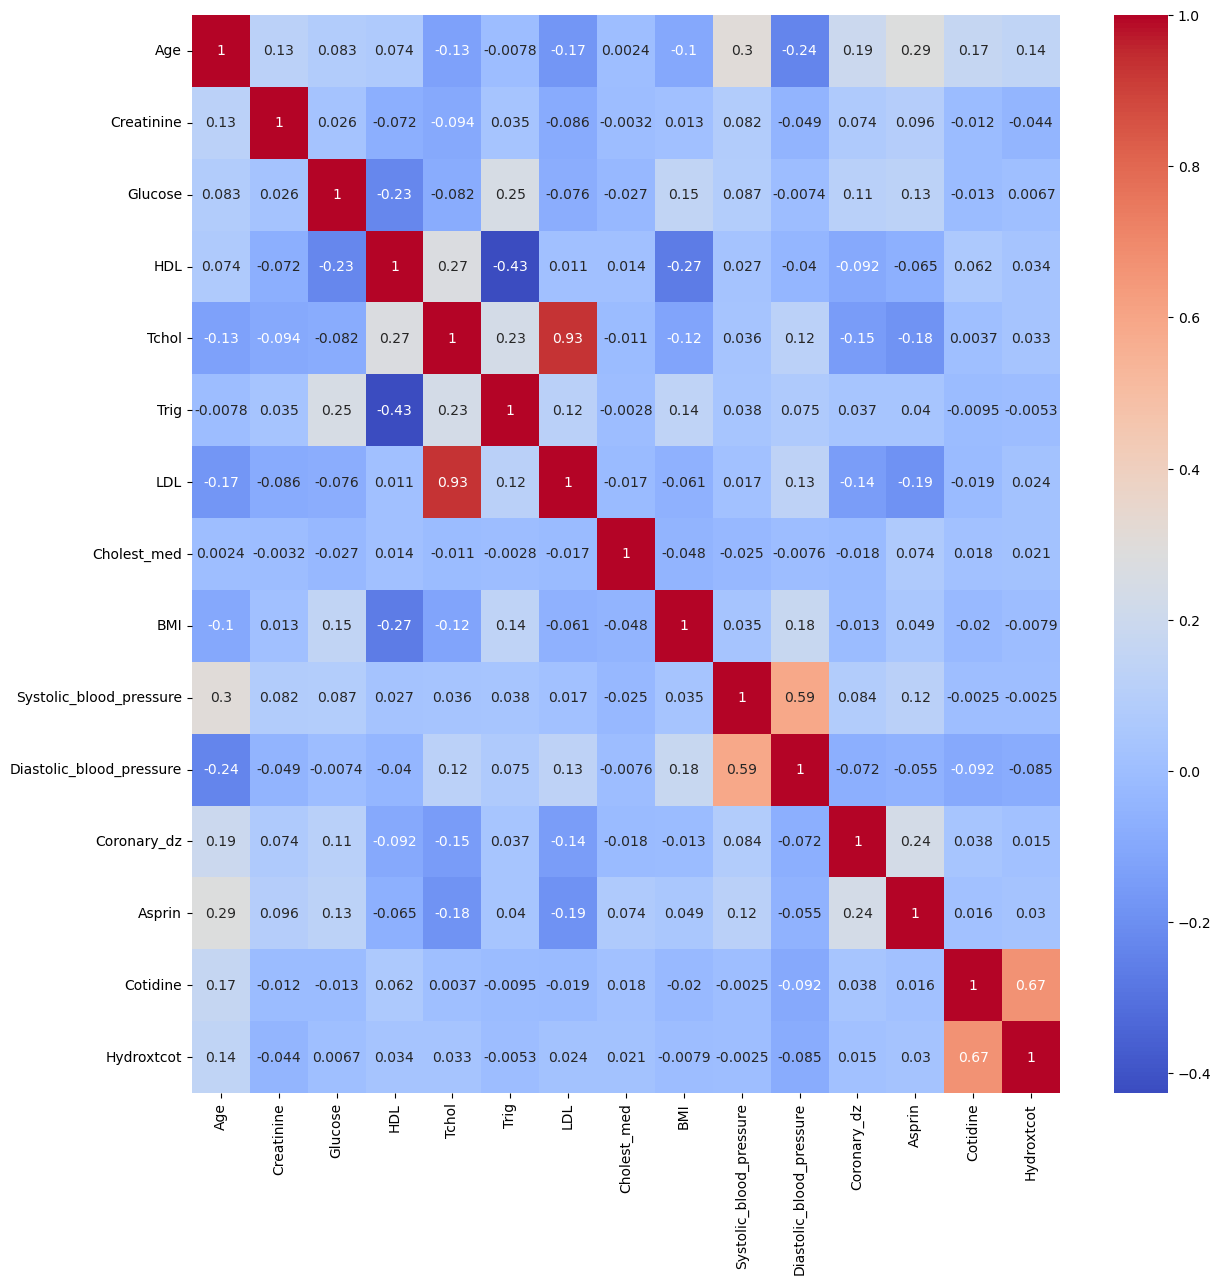

In [12]:
# Correlation Matrix of the numeric columns

matrix = data.drop(['SEQN','Smoker'],axis=1).corr(numeric_only=True)
plt.figure(figsize=(14,14))
sns.heatmap(matrix,annot=True,cmap='coolwarm')

Now, I will test new variables and their correlation with coronary disease. These correlations can be compared to the correlation matrix above.

BMI alone, interestingly, has extremely weak correlation with coronary disease. This is likely due to BMI alone being a weak metric in general since it does not acccount for body composition, which is arguably more important than the more arbitrary weight rated against height. Certain features combined with BMI, however, could be useful.

In [13]:
# Triglyceride / LDL Cholesterol
(data['Trig']/data['LDL']).corr(data['Coronary_dz'])

0.1416987721024054

The Triglyceride to LDL ratio appears to be a relatively strong indicator of coronary disease, similar in weight to LDL and Total cholesterol, which are nearly the same values.

In [14]:
# Difference between LDL and HDL
(data['LDL']/data['HDL']).corr(data['Coronary_dz'])

-0.05433539051132103

In [15]:
# Age Related Obesity:
(data['BMI']*data['Age']).corr(data['Coronary_dz'])

0.11808772084141995

## Feature Engineering
**Features to Add:**
* *Hypertension Classification* - Hypertension in the medical field is an important factor in predicting coronary disease
* *Metabolic Syndrome Predictors* - Metabolic syndrome has vast implications on health, on a wide range of long term health conditions
* *Age Related Obesity* - BMI appears to be increasingly important with Age
* *LDL/HDL Cholesterol* - Although low correlation, it is clinically significant
* *Triglyceride:LDL Cholesterol* - Key lipid marker with moderate correlation
* *Non HDL Cholesterol* - Total Cholesterol minus HDL, showing all of the "bad" cholesterols

In [16]:
# There are five levels of hypertension according to the current medical guidelines

def classify_hypertension(sbp,dbp):
    if sbp>=180 or dbp >=120:
        return 4 # Hypertensive Crisis
    elif sbp>=140 or dbp >=90:
        return 3 # Stage 2 Hypertension
    elif sbp>130 or dbp>=80:
        return 2 # Stage 1 Hypertension
    elif sbp>120 and dbp<80:
        return 1 # Elevated
    else:
        return 0 # Normal    

In [17]:
# Classify Metabolic Syndrome through: high BMI, SBP > 130 and DBO > 85, High Triglycerides, Low HDL Cholesterol, and glucose
# This will be created into an ordinal feature as well, indicating how many of the 5 markers a candidate has

def metabolic_syndrome_factors(row):
    risk_factors = 0
    if row['BMI'] >= 30:
        risk_factors += 1
    if row['Systolic_blood_pressure']>=130 or row['Diastolic_blood_pressure']>=85:
        risk_factors += 1
    if row['Trig']>=150:
        risk_factors += 1
    if row['Gender'] == 'Male' and row['HDL']<40:
        risk_factors += 1
    if row['Gender'] == 'Female' and row['HDL']<50:
        risk_factors += 1
    if row['Glucose'] >= 100:
        risk_factors += 1
    return risk_factors

In [18]:
def features(data):
    # Drop SEQN, not necessary for modeling
    data = data.drop('SEQN', axis = 1)

    # Triglyceride, HDL, and LDL relationships
    data['Trig_LDL'] = data['Trig']/data['LDL']
    data['LDL_over_HDL'] = data['LDL']/data['HDL']
    data['non_HDL'] = data['Tchol']-data['HDL']

    # Age Related Obesity
    data['Age_Obesity'] = data['Age']*data['BMI']

    # Hypertension Ordinal Factor:
    data['Hypertension'] = data.apply(lambda row: classify_hypertension(row['Systolic_blood_pressure'],row['Diastolic_blood_pressure']), axis = 1)

    # Metabolic Syndrome Feature
    data['Metabolic_Syndrome'] = data.apply(lambda row: metabolic_syndrome_factors(row), axis=1)

    # Get dummies for whichever categorical columns are passed (should just be Gender, Education, Race_Eth)
    numeric_columns = data._get_numeric_data().columns
    categorical_columns = [col for col in data.columns if col not in numeric_columns]
    data = pd.get_dummies(data = data, columns = categorical_columns)
    return data

In [19]:
new = features(data)

### New Ordinal Features Plotted:

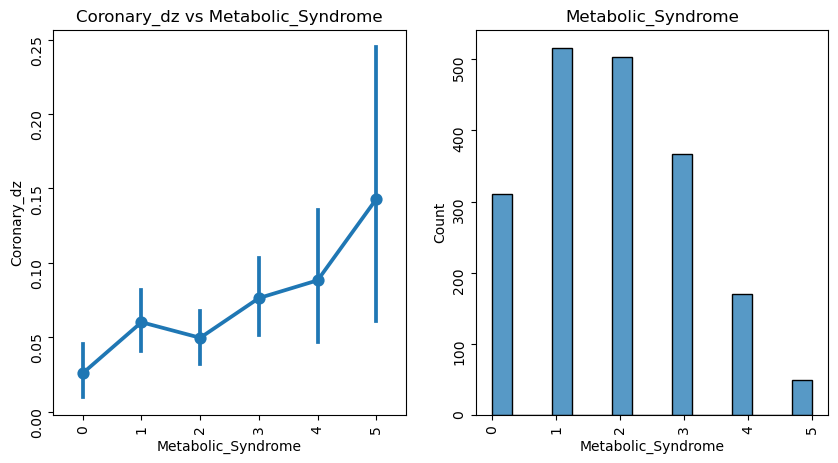

In [20]:
plotter(new,'Metabolic_Syndrome','Coronary_dz')

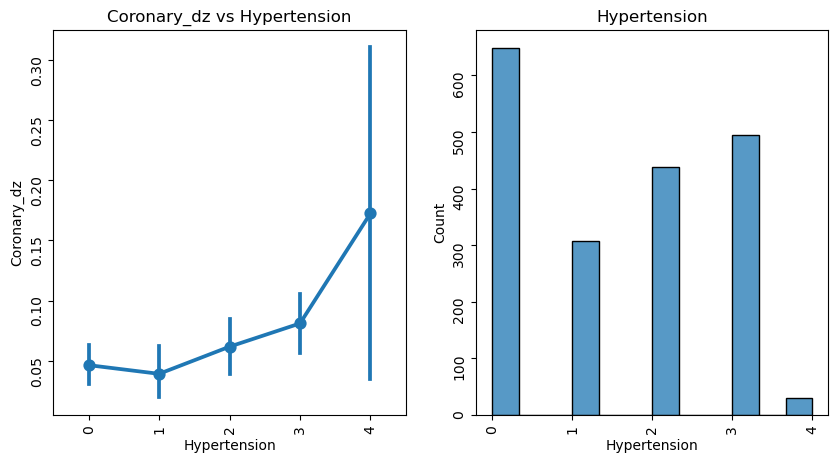

In [21]:
plotter(new,'Hypertension','Coronary_dz')

**Summary:** The Hypertenssion and Metabolic Syndrome features both showed strong positive correlation with Coronary Disease, and also resembled a Poisson distribution. Women also were shown to have much fewer cases than men. Race appeared to play a pretty strong role, alonge with Age, Choleterol levels, and Aspirin.

In [22]:
X = new.drop('Coronary_dz', axis = 1)
y = new['Coronary_dz']

## Clustering and Risk Groups

**Goal:** Develop Risk Groups so that there can be awareness of the percentage of positive cases in individuals most similar to any given patient\
**Method:** K-Means clustering, optimized with the elbow method, paired with tSNE for observing the clusters

In [23]:
# Visualize the data with t-SNE
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, OPTICS
from sklearn.metrics import davies_bouldin_score

In [24]:
def cluster(data,n_clusters):
    kmeans = KMeans(n_clusters=n_clusters,random_state=42)
    model = kmeans.fit(data)
    clusters = model.predict(data)

    return model, clusters

In [25]:
def inertia_plot(data,n_clusters, start=1):
    inertias = []
    for i in range(start,n_clusters+1):
        model, clusters = cluster(data,i)
        inertias.append(model.inertia_)
        #inertias.append(davies_bouldin_score(data,clusters))
    fig, ax = plt.subplots()

    ax.set_title('Inertia Plot')
    ax.set_ylabel('Inertia')
    ax.set_xlabel('# of Clusters')
    plt.plot(list(range(start,n_clusters+1)),inertias)

C:\Users\Sajan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Sajan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Sajan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Sajan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

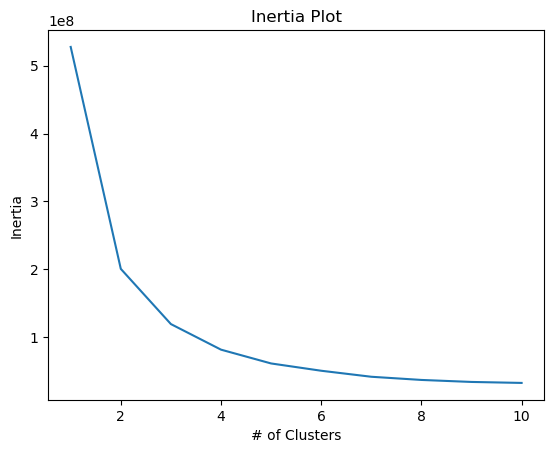

In [26]:
inertia_plot(X,10)

In [27]:
kmeans, clusters = cluster(X,n_clusters=4)
X_clustered = X.copy()
X_clustered['cluster'] = clusters

C:\Users\Sajan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


Now, we will use tSNE to transform the data in to a visualizable form, with 2 components.

In [28]:
tsne = TSNE(n_components = 2, perplexity = 50,random_state = 42)
X_transformed = tsne.fit_transform(X_clustered)
X_clustered['Coronary_dz'] = y

Text(0.5, 1.0, 'Risk Groups')

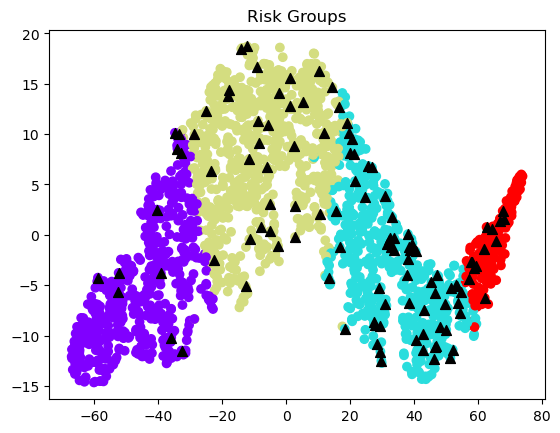

In [29]:
plt.scatter(x = X_transformed[:,0], y = X_transformed[:,1], c = clusters, cmap='rainbow')
plt.scatter(x = X_transformed[X_clustered['Coronary_dz']==1][:,0], y = X_transformed[X_clustered['Coronary_dz']==1][:,1],
            marker='^', color = 'black', s = 50)
plt.title('Risk Groups')

### Risk Group Percentage with Coronary Disease

In [30]:
X_clustered[['Coronary_dz']].groupby(X_clustered['cluster']).mean()*100

,Coronary_dz
cluster,
0,2.144250
1,10.555556
2,4.680851
3,8.227848


### Train Test Split

In [31]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .2, random_state = 42)

# Modeling Phase

## Dataset Transformations

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score

### PCA Transformation

In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

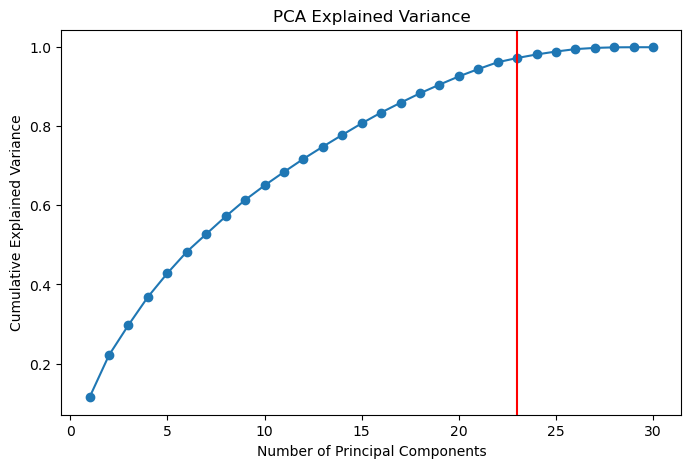

In [34]:
# PCA Explained Variance
pca = PCA(n_components = 30,random_state = 42)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
pca.fit(X_normalized)
X_transformed = pca.transform(X_normalized)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.axvline(x=23,color='red')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

23 Components were chosen as over 90% of the variance in the data was accounted for, and it cut the number of factors down nearly in half.

In [35]:
pca = PCA(n_components = 23,random_state = 42)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
pca.fit(X_normalized)
X_transformed = pca.transform(X_normalized)

### Undersampling

In [36]:
# Create a dataframe which is more closely balanced for improved model training, approximately 1:3 as opposed to 1:15
train = train_X.copy()
train['Coronary_dz'] = train_y
train_0 = train[train['Coronary_dz']==0]
train_1 = train[train['Coronary_dz']==1]

train_0_resampled = resample(train_0, n_samples = 300,replace=False,random_state=42)
train_X_undersampled = pd.concat([train_0_resampled.drop('Coronary_dz', axis=1),train_1.drop('Coronary_dz', axis=1)])
train_y_undersampled = pd.concat([train_0_resampled['Coronary_dz'],train_1['Coronary_dz']])

### Oversampling with SMOTE

In [37]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
train_X_resampled, train_y_resampled = smote.fit_resample(train_X,train_y)

### Create Functions to run and compare various models and datasets

In [38]:
# Function to run and save a model
def classifier(model,X,y,Xtest=[0],ytest=[0],called = 0,**kwargs):
    #Filter warnings from Logistic Regression
    warnings.filterwarnings('ignore')
    
    # Create Train Test Split and allow for custom train and test data
    if len(Xtest) > 5:
        X_train, X_test, y_train, y_test = X,Xtest,y,ytest
    else:
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2, random_state = 42)
        
    # Fit the model
    classifier_model = model(**kwargs)
    classifier_model.fit(X_train, y_train)

    # Make Predictions on the Test set
    predictions = classifier_model.predict(X_test)
    test_recall = recall_score(y_test,predictions)
    test_accuracy = accuracy_score(y_test,predictions)
    test_f1 = f1_score(y_test,predictions)

    # Make Predictions on the Train set
    train_preds = classifier_model.predict(X_train)
    train_recall = recall_score(y_train, train_preds)
    train_accuracy = accuracy_score(y_train,train_preds)
    train_f1 = f1_score(y_train, train_preds)

    # Cross Validation Accuracy
    cv_recall = np.mean(cross_val_score(estimator = classifier_model, X = X_train, y = y_train, scoring = 'recall'))
    cv_accuracy = np.mean(cross_val_score(estimator = classifier_model, X = X_train, y = y_train, scoring = 'accuracy'))
    cv_f1 = np.mean(cross_val_score(estimator = classifier_model, X = X_train, y = y_train, scoring = 'f1'))

    # If statement to determine whether to return the model or the results of the model testing
    if called == 0:
        return classifier_model
    else:
        return {'index':['recall','accuracy','f1_score'],'train': [train_recall, train_accuracy, train_f1], 'test':[test_recall, test_accuracy, test_f1], 'cross_validation':[cv_recall, cv_accuracy, cv_f1]}

In [39]:
# Function to compare results from untransformed data, pca transformed data, undersampled data, and smote transformed data

def classifier_transformation_comparison(model,**kwargs):
    # Regular Data
    a = classifier(model,X,y,called = 1,**kwargs)
    # PCA Transformed Data
    b = classifier(model,X_transformed,y,called = 1,**kwargs)
    # Undersampled Data
    c = classifier(model,train_X_undersampled,train_y_undersampled,test_X,test_y,called = 1,**kwargs)
    # SMOTE Data
    d = classifier(model,train_X_resampled,train_y_resampled,test_X,test_y,called = 1,**kwargs)
    
    return {'Untransformed':a,'PCA Transformed':b,'Undersampled':c,'SMOTE Transformed':d}

In [40]:
def table_comparison(table):
    for key,val in table.items():
        # Share which dataset is being  used
        print(key)

        # Create data frame from saved data
        df = pd.DataFrame(val)
        df = df.set_index(['index'])

        # Create a table of the results of each model
        tabulated = tabulate(df, headers = val.keys(), tablefmt='grid')
        print(tabulated)

### Random Forest Classifier

In [41]:
random_forest_comparison = classifier_transformation_comparison(RandomForestClassifier,random_state=42)
table_comparison(random_forest_comparison)

Untransformed
+----------+---------+----------+--------------------+
| index    |   train |     test |   cross_validation |
+==========+=========+==========+====================+
| recall   |       1 | 0        |          0.0105263 |
+----------+---------+----------+--------------------+
| accuracy |       1 | 0.950521 |          0.938641  |
+----------+---------+----------+--------------------+
| f1_score |       1 | 0        |          0.02      |
+----------+---------+----------+--------------------+
PCA Transformed
+----------+---------+----------+--------------------+
| index    |   train |     test |   cross_validation |
+==========+=========+==========+====================+
| recall   |       1 | 0        |           0        |
+----------+---------+----------+--------------------+
| accuracy |       1 | 0.950521 |           0.936682 |
+----------+---------+----------+--------------------+
| f1_score |       1 | 0        |           0        |
+----------+---------+----------+--

### Gradient Boosting Classifier

In [42]:
gradient_boosting_comparison = classifier_transformation_comparison(GradientBoostingClassifier,random_state=42)
table_comparison(gradient_boosting_comparison)

Untransformed
+----------+----------+----------+--------------------+
| index    |    train |     test |   cross_validation |
+==========+==========+==========+====================+
| recall   | 0.642105 | 0.105263 |          0.0631579 |
+----------+----------+----------+--------------------+
| accuracy | 0.977154 | 0.945312 |          0.927551  |
+----------+----------+----------+--------------------+
| f1_score | 0.77707  | 0.16     |          0.0919984 |
+----------+----------+----------+--------------------+
PCA Transformed
+----------+----------+-----------+--------------------+
| index    |    train |      test |   cross_validation |
+==========+==========+===========+====================+
| recall   | 0.778947 | 0.0526316 |          0.0526316 |
+----------+----------+-----------+--------------------+
| accuracy | 0.986292 | 0.950521  |          0.926897  |
+----------+----------+-----------+--------------------+
| f1_score | 0.87574  | 0.0952381 |          0.0821672 |
+---------

### Decision Tree Classifier

In [43]:
decision_tree_comparison = classifier_transformation_comparison(DecisionTreeClassifier,random_state=42)
table_comparison(decision_tree_comparison)

Untransformed
+----------+---------+----------+--------------------+
| index    |   train |     test |   cross_validation |
+==========+=========+==========+====================+
| recall   |       1 | 0.210526 |           0.178947 |
+----------+---------+----------+--------------------+
| accuracy |       1 | 0.885417 |           0.893602 |
+----------+---------+----------+--------------------+
| f1_score |       1 | 0.153846 |           0.162222 |
+----------+---------+----------+--------------------+
PCA Transformed
+----------+---------+----------+--------------------+
| index    |   train |     test |   cross_validation |
+==========+=========+==========+====================+
| recall   |       1 | 0.263158 |           0.115789 |
+----------+---------+----------+--------------------+
| accuracy |       1 | 0.90625  |           0.890341 |
+----------+---------+----------+--------------------+
| f1_score |       1 | 0.217391 |           0.111919 |
+----------+---------+----------+--

### Logistic Regression

In [44]:
logreg_comparison = classifier_transformation_comparison(LogisticRegression,max_iter=10000)
table_comparison(logreg_comparison)

Untransformed
+----------+-----------+-----------+--------------------+
| index    |     train |      test |   cross_validation |
+==========+===========+===========+====================+
| recall   | 0.0736842 | 0.0526316 |          0.0631579 |
+----------+-----------+-----------+--------------------+
| accuracy | 0.939295  | 0.947917  |          0.932122  |
+----------+-----------+-----------+--------------------+
| f1_score | 0.130841  | 0.0909091 |          0.102507  |
+----------+-----------+-----------+--------------------+
PCA Transformed
+----------+-----------+-----------+--------------------+
| index    |     train |      test |   cross_validation |
+==========+===========+===========+====================+
| recall   | 0.0736842 | 0.0526316 |          0.0631579 |
+----------+-----------+-----------+--------------------+
| accuracy | 0.939295  | 0.947917  |          0.93147   |
+----------+-----------+-----------+--------------------+
| f1_score | 0.130841  | 0.0909091 |      

### Analysis of Results
**Data Comparison:** In the modeling phase, I was testing Untransformed, and getting really poor results for recall due to the large imbalance in the data set. I wasn't sure of the cause initially, and thought it might be due to overfitting, so I tried PCA to reduce dimensions and maintain most of the variance in the data. Standard Scaling with PCA actually made great improvements in the ability of the model for all but RandomForestClassifier, indicating it allowed the model to generalize better. There was less overfitting it seemed.

After trying PCA, I went with undersampling to try to provide the model with a more balanced training set. This had massive improvements to the model both in overfitting and performance, which was exciting to see. Since I tried undersampling, I also wanted to try SMOTE and see how they compared. SMOTE ended up performing much better than the untransformed, but surprisingly worse than PCA, except for on RandomForestClassifier. It also had strong overfitting and didn't perform nearly as well as undersampling on new data.

**Model Comparison:** Interestingly, the model that performed the best on new data was the *Logistic Regression* and *Decision Tree Classifier* on the undersampled data. The *Random Forest Classifier* and *Gradient Boosting Classifier* each performed well on undersampled data, but potentially due to the small amount of rows they didn't perform as well.

**Next Steps:** 
* Hyperparameter tuning on the best model/dataset for *Undersampling*
* Pick the model and run the holdoutset through the model
* SHAP for feature importances

## Hyperparameter Tuning

### Random Forest

In [45]:
# Scoring parameter
scoring_parameter = 'balanced_accuracy'

In [46]:
# Random Forest Parameter Grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees (higher = better but slower)
    'max_depth': [10, 20, 30, None],  # Tree depth (None lets it grow fully)
    'min_samples_split': [2, 5, 10],  # Minimum samples to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples to form a leaf node
    'max_features': ['sqrt', 'log2'],  # Features considered at each split
    'class_weight': ['balanced', 'balanced_subsample', None],  # Handle class imbalance
    'bootstrap': [True],  # Bootstrap sampling (generally True for RF)
    'random_state': [42]  # Random State
}

In [47]:
tuned_rf = RandomizedSearchCV(RandomForestClassifier(), param_distributions = param_grid,scoring=scoring_parameter,n_iter=100,cv=5)

In [48]:
tuned_rf.fit(train_X_undersampled,train_y_undersampled)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample',
                                                         None],
                                        'max_depth': [10, 20, 30, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300],
                                        'random_state': [42]},
                   scoring='balanced_accuracy')

In [49]:
tuned_rf.best_params_

{'random_state': 42,
 'n_estimators': 300,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 20,
 'class_weight': 'balanced_subsample',
 'bootstrap': True}

In [50]:
tuned_rf_predictions = tuned_rf.predict(test_X)

#### Tuned Random Forest

In [51]:
print(classification_report(test_y, tuned_rf_predictions))

              precision    recall  f1-score   support

         0.0       0.97      0.88      0.92       365
         1.0       0.16      0.42      0.23        19

    accuracy                           0.86       384
   macro avg       0.56      0.65      0.58       384
weighted avg       0.93      0.86      0.89       384



#### Untuned Random Forest

In [52]:
untuned_rf = RandomForestClassifier()
untuned_rf.fit(train_X_undersampled,train_y_undersampled)
untuned_rf_predictions = untuned_rf.predict(test_X)
print(classification_report(test_y,untuned_rf_predictions))

              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95       365
         1.0       0.19      0.32      0.24        19

    accuracy                           0.90       384
   macro avg       0.58      0.62      0.59       384
weighted avg       0.93      0.90      0.91       384



**Random Forest Summary:** The Random Forest model performed well untuned and tuned, but needed to be optimized to better classify the positive cases of Coronary Disease. Overall, a mid level model performance.

### Gradient Boosting Classifier

In [53]:
# Gradient Boosting Parameter Grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'subsample': [0.8, 1.0],
    'random_state': [42]
}

In [54]:
tuned_gb = RandomizedSearchCV(GradientBoostingClassifier(),param_distributions = param_grid,scoring=scoring_parameter,n_iter=100,cv=5)

In [55]:
tuned_gb.fit(train_X_undersampled,train_y_undersampled)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=100,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300],
                                        'random_state': [42],
                                        'subsample': [0.8, 1.0]},
                   scoring='balanced_accuracy')

In [56]:
tuned_gb.best_params_

{'subsample': 0.8,
 'random_state': 42,
 'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 3,
 'learning_rate': 0.2}

In [57]:
tuned_gb_predictions = tuned_gb.predict(test_X)

#### Tuned Gradient Boost

In [58]:
print(classification_report(test_y,tuned_gb_predictions))

              precision    recall  f1-score   support

         0.0       0.97      0.87      0.91       365
         1.0       0.14      0.42      0.21        19

    accuracy                           0.85       384
   macro avg       0.55      0.64      0.56       384
weighted avg       0.93      0.85      0.88       384



#### Untuned Gradient Boost

In [59]:
untuned_gb = GradientBoostingClassifier()
untuned_gb.fit(train_X_undersampled,train_y_undersampled)
untuned_gb_predictions = untuned_gb.predict(test_X)
print(classification_report(test_y,untuned_gb_predictions))

              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93       365
         1.0       0.17      0.37      0.23        19

    accuracy                           0.88       384
   macro avg       0.57      0.64      0.58       384
weighted avg       0.93      0.88      0.90       384



**Gradient Boost Summary:** The Gradient Boosting Classifier performed slightly better untuned than it did with RandomSearchCV, and was very similar to the Random Forest Classifier in performance, but with higher recall on the positives.

### Decision Tree Classifier

In [60]:
# Decision Tree Classifier Parameter Grid
param_grid = {
    'criterion': ['gini', 'entropy'],  
    'splitter': ['best', 'random'],  
    'max_depth': [10, 20, 30, None],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],  
    'max_features': ['sqrt', 'log2', None],  
    'class_weight': ['balanced', None],  
    'random_state': [42]  
}

In [61]:
tuned_dt = RandomizedSearchCV(DecisionTreeClassifier(),param_distributions = param_grid,scoring=scoring_parameter,n_iter=100,cv=5)

In [62]:
tuned_dt.fit(train_X_undersampled,train_y_undersampled)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=100,
                   param_distributions={'class_weight': ['balanced', None],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'random_state': [42],
                                        'splitter': ['best', 'random']},
                   scoring='balanced_accuracy')

In [63]:
tuned_dt.best_params_

{'splitter': 'random',
 'random_state': 42,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': None,
 'criterion': 'entropy',
 'class_weight': 'balanced'}

In [64]:
tuned_dt_predictions = tuned_dt.predict(test_X)

#### Tuned Decision Tree

In [65]:
print(classification_report(test_y,tuned_dt_predictions))

              precision    recall  f1-score   support

         0.0       0.96      0.58      0.72       365
         1.0       0.07      0.58      0.12        19

    accuracy                           0.58       384
   macro avg       0.52      0.58      0.42       384
weighted avg       0.92      0.58      0.69       384



#### Untuned Decision Tree

In [66]:
untuned_dt = DecisionTreeClassifier()
untuned_dt.fit(train_X_undersampled,train_y_undersampled)
untuned_dt_predictions = untuned_dt.predict(test_X)
print(classification_report(test_y,untuned_dt_predictions))

              precision    recall  f1-score   support

         0.0       0.98      0.77      0.86       365
         1.0       0.13      0.63      0.21        19

    accuracy                           0.77       384
   macro avg       0.55      0.70      0.54       384
weighted avg       0.93      0.77      0.83       384



**Decision Tree Summary:** The deicision tree performed overall very well, and saw improvements in the recall through hyperparameter tuning. It had a high recall and precision, and is so far the best model.

### Logistic Regression

In [67]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],  
    'C': [0.01, 0.1, 1, 10, 100],  
    'solver': ['liblinear', 'lbfgs', 'saga'],  
    'max_iter': [100, 200, 500],  
    'class_weight': ['balanced', None],  
    'random_state': [42]  
}

In [68]:
tuned_lr = RandomizedSearchCV(LogisticRegression(),param_distributions = param_grid,scoring=scoring_parameter,n_iter=100,cv=5)

In [69]:
tuned_lr.fit(train_X_undersampled,train_y_undersampled)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=100,
                   param_distributions={'C': [0.01, 0.1, 1, 10, 100],
                                        'class_weight': ['balanced', None],
                                        'max_iter': [100, 200, 500],
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    None],
                                        'random_state': [42],
                                        'solver': ['liblinear', 'lbfgs',
                                                   'saga']},
                   scoring='balanced_accuracy')

In [70]:
tuned_lr.best_params_

{'solver': 'lbfgs',
 'random_state': 42,
 'penalty': None,
 'max_iter': 500,
 'class_weight': 'balanced',
 'C': 1}

In [71]:
tuned_lr_predictions = tuned_lr.predict(test_X)

#### Tuned Logistic Regression

In [72]:
print(classification_report(test_y,tuned_lr_predictions))

              precision    recall  f1-score   support

         0.0       0.98      0.76      0.85       365
         1.0       0.14      0.74      0.23        19

    accuracy                           0.76       384
   macro avg       0.56      0.75      0.54       384
weighted avg       0.94      0.76      0.82       384



#### Untuned Logistic Regression

In [73]:
untuned_lr = LogisticRegression()
untuned_lr.fit(train_X_undersampled,train_y_undersampled)
untuned_lr_predictions = untuned_lr.predict(test_X)
print(classification_report(test_y,untuned_lr_predictions))

              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94       365
         1.0       0.19      0.37      0.25        19

    accuracy                           0.89       384
   macro avg       0.58      0.64      0.60       384
weighted avg       0.93      0.89      0.91       384



**Logistic Regression Summary:** The Logistic Regression had the highest precision on the negative class, which is the goal for this model. It saw huge improvements through hyperparameter tuning. The top two models are Logistic Regression and Decision Tree Classifier to move on to industry.

### Tuned Models - ROC curves

In [74]:
def ROC_curve(model):
    probabilities = (model.predict_proba(test_X)[:,1])
    fpr, tpr, thresh = roc_curve(test_y,probabilities)
    roc_auc = auc(fpr, tpr)

    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b', label = f'AUC = {roc_auc}')
    plt.legend(loc = 'best')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    return fpr, tpr, thresh

In [75]:
def maximize_recall(fpr,tpr,thresh):
    zipped = list(zip(tpr,thresh,fpr))
    to = []
    for i in range(len(zipped)):
        if zipped[i][0] == 1:
            to.append(zipped[i])
    zipped = sorted(to, key=lambda x: x[1],reverse=True)
    threshold = zipped[0][1]
    false = zipped[0][2]
    true = zipped[0][0]
    print(f'(fpr,tpr,thresh) for recall of 1: {false,true,threshold}')
    return false,true,threshold

def maximize_negative_predictive_value(fpr,tpr,thresh):
    zipped = list(zip(tpr,thresh,fpr))
    to = []
    for i in range(len(zipped)):
        if zipped[i][2] == 0:
            to.append(zipped[i])
    zipped = sorted(to, key=lambda x: x[1],reverse=False)
    threshold = zipped[0][1]
    false = zipped[0][2]
    true = zipped[0][0]
    print(f'(fpr,tpr,thresh) for no false negatives: {false,true,threshold}')
    return false,true,threshold

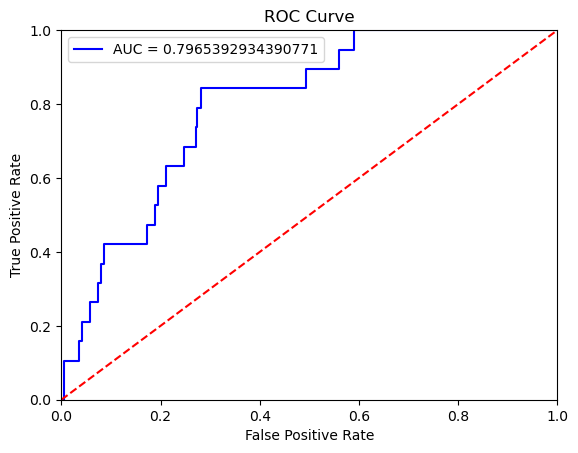

(fpr,tpr,thresh) for recall of 1: (0.589041095890411, 1.0, 0.18300763355417599)
(fpr,tpr,thresh) for no false negatives: (0.0, 0.0, inf)


(0.0, 0.0, inf)

In [76]:
fpr, tpr, thresh = ROC_curve(tuned_rf)
maximize_recall(fpr,tpr,thresh)
maximize_negative_predictive_value(fpr,tpr,thresh)

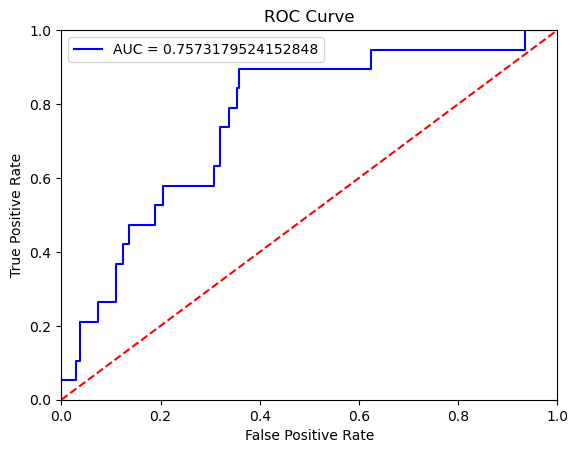

(fpr,tpr,thresh) for recall of 1: (0.9342465753424658, 1.0, 0.00028465752852979345)
(fpr,tpr,thresh) for no false negatives: (0.0, 0.05263157894736842, 0.9953599693387797)


(0.0, 0.05263157894736842, 0.9953599693387797)

In [77]:
fpr, tpr, thresh = ROC_curve(tuned_gb)
maximize_recall(fpr,tpr,thresh)
maximize_negative_predictive_value(fpr,tpr,thresh)

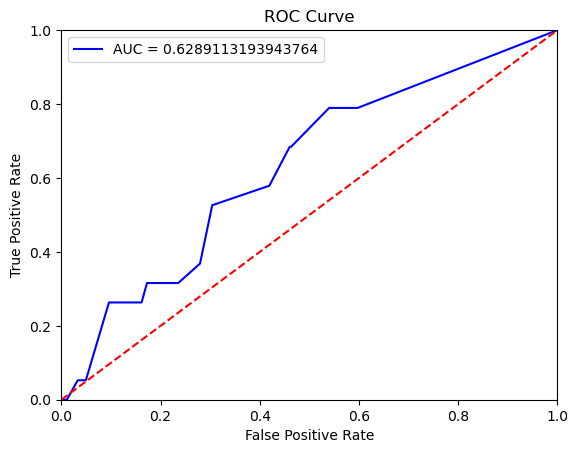

(fpr,tpr,thresh) for recall of 1: (1.0, 1.0, 0.0)
(fpr,tpr,thresh) for no false negatives: (0.0, 0.0, inf)


(0.0, 0.0, inf)

In [78]:
fpr, tpr, thresh = ROC_curve(tuned_dt)
maximize_recall(fpr,tpr,thresh)
maximize_negative_predictive_value(fpr,tpr,thresh)

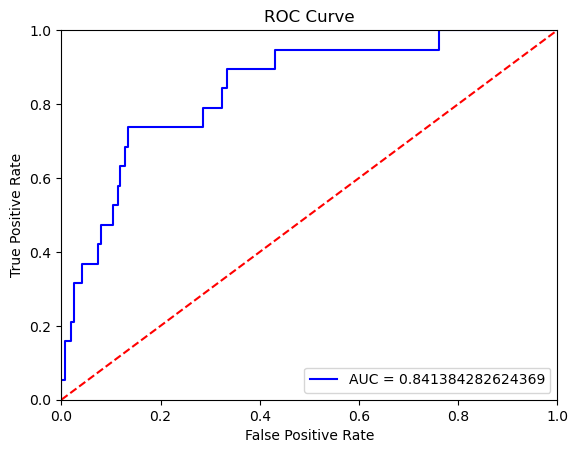

(fpr,tpr,thresh) for recall of 1: (0.7616438356164383, 1.0, 0.09512111265486027)
(fpr,tpr,thresh) for no false negatives: (0.0, 0.05263157894736842, 0.9513748388870813)


(0.0, 0.05263157894736842, 0.9513748388870813)

In [79]:
fpr, tpr, thresh = ROC_curve(tuned_lr)
maximize_recall(fpr,tpr,thresh)
maximize_negative_predictive_value(fpr,tpr,thresh)

## Modeling Conclusion
**Best Model:** Logistic Regression\
**Best Training Technique:** Undersampling

The Logistic Regression was the best model, but the other three models will move on to the next phase both out of curiosity and skepticism that Logistic Regression will perform best in industry. The Decision Tree Classifier was a close second, with the ensemble models performing much worse. However, this strong performance in Logistic Regression could be due to the continuous nature of the majority of the variables, with risk factors generally increasing or decreasing consistently in each category.

**Next Steps:**
* Test Logistic Regression, Decision Tree Classifier, Gradient Boosting Classifier, and Random Forest Classifier on Holdout Data
* SHAP for feature importance on the holdout data

### Dump Best Model to Pickle

In [80]:
# Random Forest to Pickle file
rf_file = 'randfor.pkl'
pickle.dump(tuned_rf.best_estimator_, open(rf_file, 'wb'))

In [81]:
# Gradient Boosting Classifier to Pickle file
gb_file = 'gradboo.pkl'
pickle.dump(tuned_gb.best_estimator_, open(gb_file,'wb'))

In [82]:
# Decision Tree Classifier to Pickle file
dt_file = 'dectree.pkl'
pickle.dump(tuned_dt.best_estimator_,open(dt_file,'wb'))

In [83]:
# Logistic Regression to Pickle file
lr_file = 'linreg.pkl'
pickle.dump(tuned_lr.best_estimator_, open(lr_file, 'wb'))

### Make Predictions on Holdout Data using top three models

In [84]:
# Read in holdout data and run through feature engineering and add columns that did not carry over
holdout = pd.read_csv('holdout_data.csv')

# post feature engineering features:
data_post_FE = features(holdout)

# Find columns that are in the training set but not the holdout set
new_columns = list(set(new.columns)-set(data_post_FE.columns))

# Add a column of zeros to the holdout set for all new columns
for name in new_columns:
    data_post_FE[name] = 0*len(data_post_FE)

# Reindex to the same order as the training set
data_post_FE = data_post_FE.reindex(columns = new.columns)

# Split to X and y
data_post_FE_X = data_post_FE.drop('Coronary_dz',axis=1)
data_post_FE_y = data_post_FE['Coronary_dz']

In [85]:
Random_Forest_Final = pickle.load(open(rf_file, 'rb'))
Gradient_Boosting_Final = pickle.load(open(gb_file, 'rb'))
Decision_Tree_Final = pickle.load(open(dt_file, 'rb'))
Logistic_Regression_Final = pickle.load(open(lr_file,'rb'))

In [86]:
Final_RF_predictions = Random_Forest_Final.predict(data_post_FE_X)
Final_GB_predictions = Gradient_Boosting_Final.predict(data_post_FE_X)
Final_DT_predictions = Decision_Tree_Final.predict(data_post_FE_X)
Final_LR_predictions = Logistic_Regression_Final.predict(data_post_FE_X)

In [87]:
print('Random Forest Classification Report:')
print(confusion_matrix(data_post_FE_y,Final_RF_predictions))
print(classification_report(data_post_FE_y,Final_RF_predictions))

Random Forest Classification Report:
[[394  50]
 [ 17  18]]
              precision    recall  f1-score   support

         0.0       0.96      0.89      0.92       444
         1.0       0.26      0.51      0.35        35

    accuracy                           0.86       479
   macro avg       0.61      0.70      0.64       479
weighted avg       0.91      0.86      0.88       479



In [88]:
print('Gradient Boosting Classification Report:')
print(confusion_matrix(data_post_FE_y,Final_GB_predictions))
print(classification_report(data_post_FE_y,Final_GB_predictions))

Gradient Boosting Classification Report:
[[406  38]
 [ 18  17]]
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.94       444
         1.0       0.31      0.49      0.38        35

    accuracy                           0.88       479
   macro avg       0.63      0.70      0.66       479
weighted avg       0.91      0.88      0.89       479



In [89]:
print('Decision Tree Classification Report:')
print(confusion_matrix(data_post_FE_y,Final_DT_predictions))
print(classification_report(data_post_FE_y,Final_DT_predictions))

Decision Tree Classification Report:
[[275 169]
 [ 13  22]]
              precision    recall  f1-score   support

         0.0       0.95      0.62      0.75       444
         1.0       0.12      0.63      0.19        35

    accuracy                           0.62       479
   macro avg       0.54      0.62      0.47       479
weighted avg       0.89      0.62      0.71       479



In [90]:
print('Logistic Regression Classification Report:')
print(confusion_matrix(data_post_FE_y,Final_LR_predictions))
print(classification_report(data_post_FE_y,Final_LR_predictions))

Logistic Regression Classification Report:
[[348  96]
 [  9  26]]
              precision    recall  f1-score   support

         0.0       0.97      0.78      0.87       444
         1.0       0.21      0.74      0.33        35

    accuracy                           0.78       479
   macro avg       0.59      0.76      0.60       479
weighted avg       0.92      0.78      0.83       479



## SHAP Random Forest Classifier

In [91]:
# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(Random_Forest_Final)

# Compute SHAP values
shap_values = explainer(data_post_FE_X)  # Use shap_values(), NOT explainer() directly

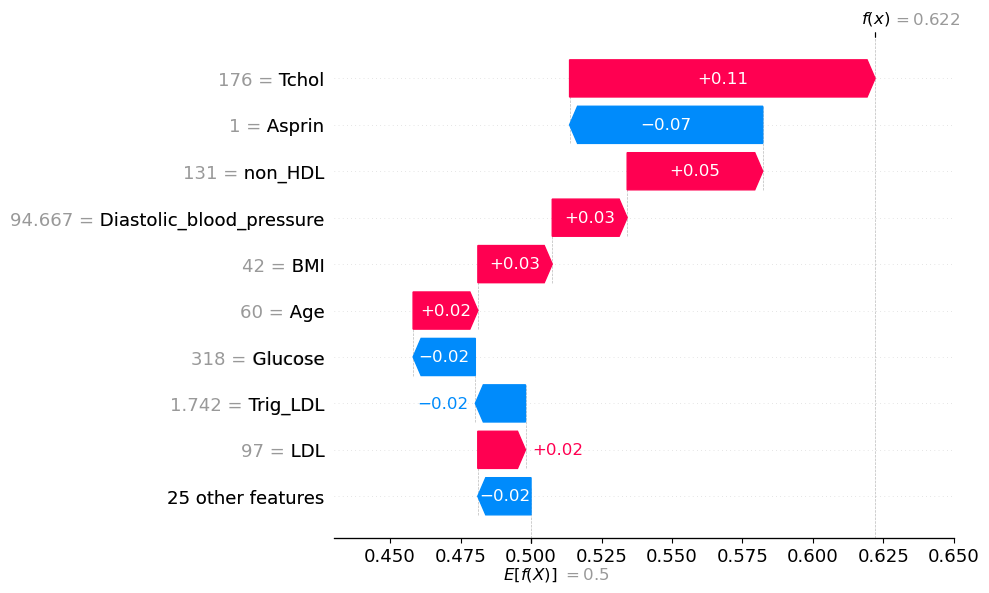

In [92]:
shap.waterfall_plot(shap_values[1][:,0])

**Top 5 Features:** 
* Total Cholesterol
* Aspirin (against)
* non-HDL Cholesterol
* Diastolic Blood Pressure
* BMI

The Random Forest Classifier had a few strong predictors for, and showed that taking aspirin decreased odds of Coronary Disease. Interestingly, my family is prone to coronary disease, and my dad has been taking preventative aspirin for a few years now.

## SHAP Gradient Boosting Classifier

In [93]:
# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(Gradient_Boosting_Final)

# Compute SHAP values
shap_values = explainer(data_post_FE_X)  # Use shap_values(), NOT explainer() directly

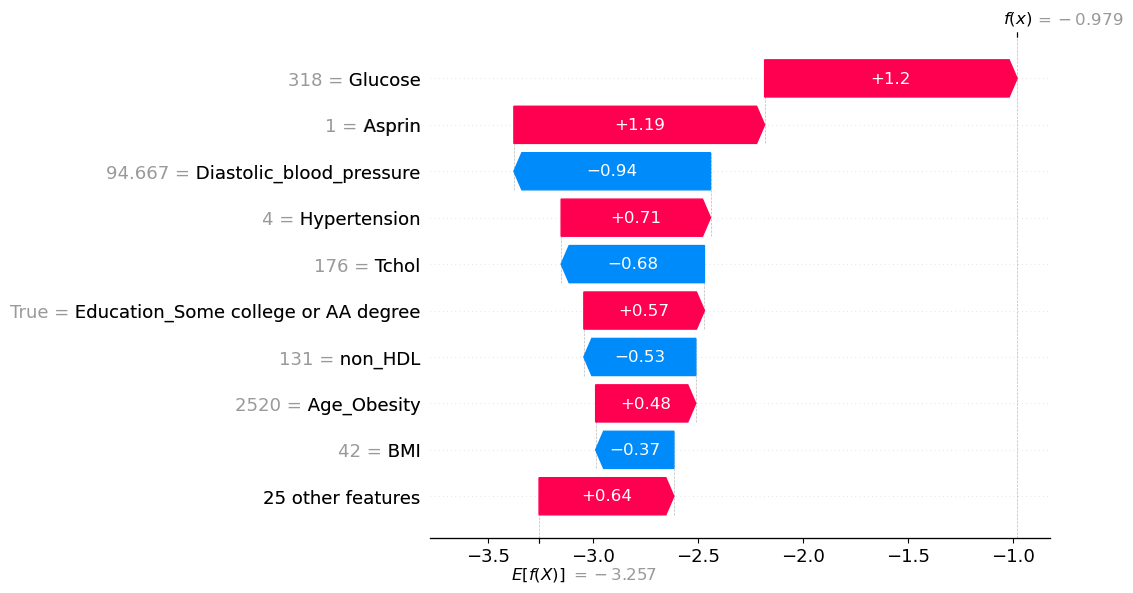

In [94]:
shap.waterfall_plot(shap_values[1])

**Top 5 Features:**
* Glucose
* Aspirin
* Diastolic Blood Pressure (against)
* Hypertensive Crisis
* Total Cholesterol (against)

Interestingly, Gradient Boosting Classifier showed Aspirin as a predictor for Coronary Disease, and Total Cholesterol as a predictor against Coronary Disease. 

## SHAP Decision Tree Classifier

In [95]:
# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(Decision_Tree_Final)

# Compute SHAP values
shap_values = explainer(data_post_FE_X)  # Use shap_values(), NOT explainer() directly

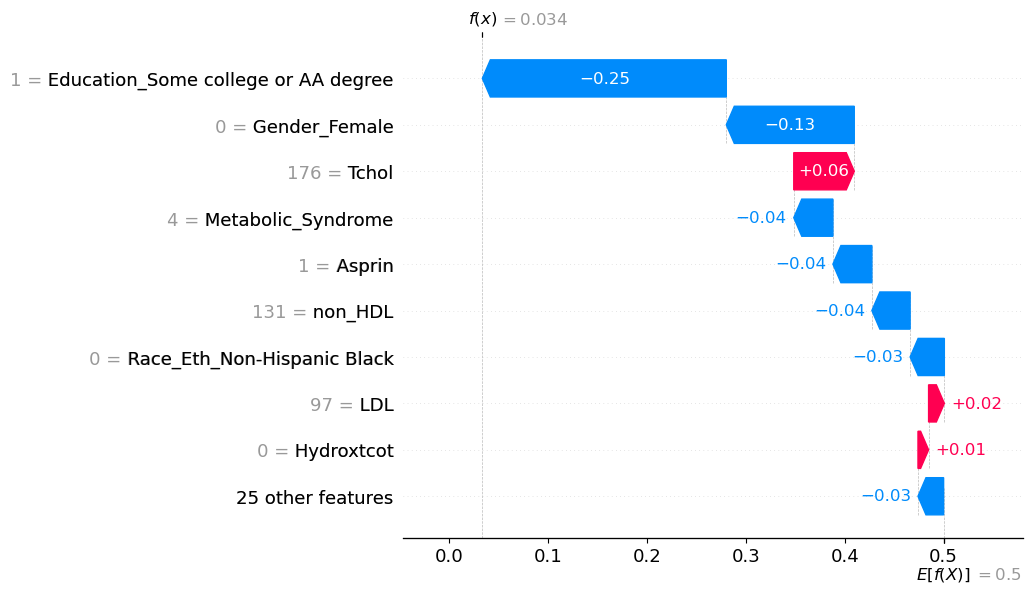

In [96]:
shap.waterfall_plot(shap_values[1][:,0])

**Top 5 Features:** 
* Education - some college or AA (against)
* Female (against)
* Total Cholesterol
* 4 Metabolic Syndrome Predictors
* Aspirin (against)

The Decision Tree Classifier had its strongest predictors mainly being against Coronary Disease. Total Cholesterol was a predictor for Coronary Disease, whereas in the Gradiet Boosting Classifier it had been a predictor against CD.

## SHAP Logistic Regression

In [97]:
explainer = shap.LinearExplainer(Logistic_Regression_Final, train_X_undersampled, feature_perturbation="interventional")
shap_values = explainer(data_post_FE_X)

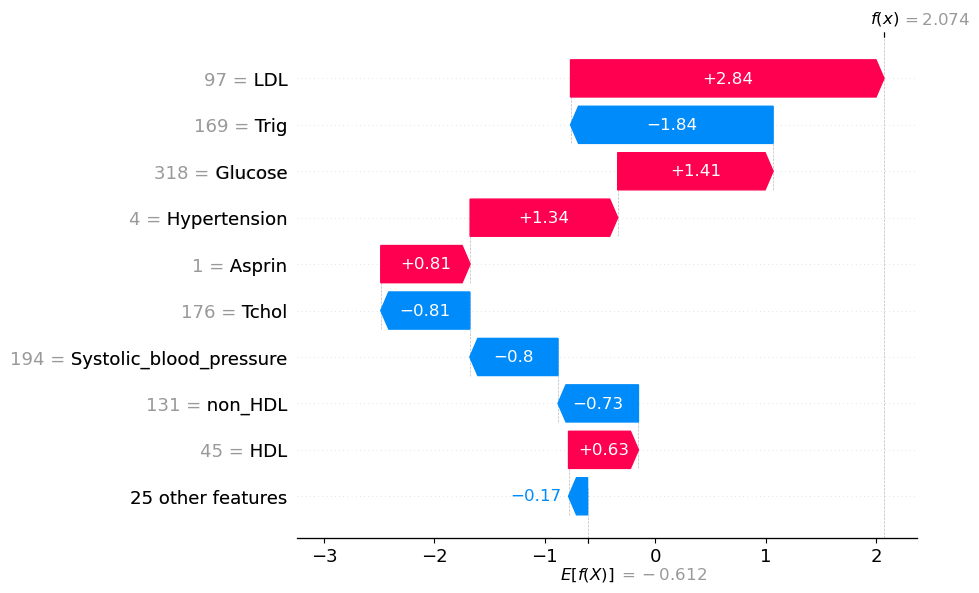

In [98]:
shap.waterfall_plot(shap_values[1])

**Top 5 Features:** 
* LDL Cholesterol
* Triglycerides
* Glucose
* Hypertensive Crisis
* Aspirin

In the Logistic Regression, hypertensive crisis was shown to be a strong part of the model. LDL Cholesterol and Triglycerides are also generally strong predictors for coronary disease, but interestingly they oppose each other.

## Conclusion
**Best Performing Model:** Logistic Regression\
Since our goal is to determine which patients almost definitely do not need further testing, we want a high precision on the negatives. The Logistic Regression best matches the goal of a model that has very high precision on the negative class. The Decision Tree Classifier performed second best, with a high recall and precision compared to both of the ensemble models.

**Feature Importances:** The Logistic Regression had LDL Cholesterol as a strong predictor for Coronary Disease, but also had Triglycerides at a similar strength in the opposite direction. Glucose, Hypertensive Crisis, and Aspirin were all strong predictors for Coronary Disease as well. These two continuous features are highly related to Coronary Disease in the medical field, and an interesting though can be brought up about Aspirin. If someone is taking Aspirin, is it more likely that they were already at risk? If they are at risk, does it also decrease their chances of having Coronary Disease? Possibly, the Aspirin acts as some sort of latent factor in some models, and its effect alone is brought out in others.

**Real-World Impact:** Between the Risk Level Clustering and the Classification Model, physicians will be provided with a couple of key indicators on whether to move forward with testing. From an initial modeling phase of extremely low recall, to an 74% recall on the positive class with 97% precision on the negative class, the classifier performed pretty well. Additionally, the risk groups show clear trends, and there is a stark contrast between the positive percentages across groups.
However, while the model appears to have performed very well, Bayes Theorem would tell us not to trust it. In the case where someone actually does have Coronary Disease, 26% of the time they will be classified as negative for CD. This is a key metric in determining whether a healthcare model can be used. Individuals have so much to lose in the case of an incorrect prediction. Sending someone home is life or death. My hope is that this tool could be used to assist physicians in determining which patients are at high risk, and using feature importances, could determine which factors an individual may need to work on to best decrease their chances.

## Next Steps
**Data/Features:**
* Someones VO2 max could be a strong indicator of their cardiovascular health.
* An individual's strength levels could be an indicator in a similar way, and I'd really like to see what SHAP importances look like between those two.
* Heart Rate Variability is a measure of cardiovascular health as well, with lower HRV showing more stress on the heart.

**Modeling:**
* Stacking Model, taking the output classification or likelihood as an input in another model.
* Averaging Probabilities between Logistic Regression and Decision Tree classifier and test for improved performance.
* Deep Learning Implementation

**Deployment:** 
* Deploy the model in an app with the features as inputs.
* Fit individuals into the risk level groups.
* Provide each individual's classification for Coronary Disease.
* Show Feature Importance SHAP plot for each individual, to show what they need to work on.